# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval

import audio_functions as af
import audio_models
import dataset

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


### Get the variables and data ready

In [2]:
#  Set variables
sample_rate=8192
n_fft=1024
fft_hop=256
patch_window=128
patch_hop=64
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '85/85-9'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

data

<PrefetchDataset shapes: ((?, 128, 513, 2), (?, 128, 513, 2), (?, 32512, 1), (?, 32512, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [3]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, name='U_Net_Model')

tf_config = tf.ConfigProto()
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [4]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/85/85-9


### Run a batch

In [69]:
mix_mag, mix_phase, voice_mag, voice_est_mag, mask, voice_wave, mix_wave = sess.run([model.mixed_mag, 
                                                                                     model.mixed_phase, 
                                                                                     model.voice_mag,
                                                                                     model.gen_voice, 
                                                                                     model.voice_mask, 
                                                                                     model.voice_audio, 
                                                                                     model.mixed_audio],
                                                                                    {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)



### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [56]:
voice_est_wave .shape

(5, 32512, 1)

In [70]:
def normalise_audio(audio):
    norm_audio = 2*((audio - audio.min())/(audio.max()-audio.min())) - 1
    return norm_audio

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = normalise_audio(mix_wave[i,:,:])

In [75]:
i=2
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

5
32512


In [72]:
# Estimate the background noise by subtracting the isolated voice and estimated voice from the mixture
bg_ref_mag = mix_mag - voice_mag
bg_est_mag = mix_mag - voice_est_mag
bg_ref_wave = []
bg_est_wave = []
for i in range(bg_ref_mag.shape[0]):
    bg_ref_wave.append(af.spectrogramToAudioFile(np.squeeze(bg_ref_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))
    
for i in range(bg_est_mag.shape[0]):
    bg_est_wave.append(af.spectrogramToAudioFile(np.squeeze(bg_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))

In [73]:
bg_ref_wave = mix_wave - voice_wave
bg_est_wave = mix_wave - voice_est_wave

In [74]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(batch_size):
    ref_sources.append(np.concatenate((voice_wave[i], bg_ref_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[ 7.43738007  7.77603946]
 [12.83135688  7.73703674]
 [16.07197461 13.01155632]
 [ 8.08659825  9.3551289 ]
 [14.92458883  6.10629333]] 
SIR
 [[11.60324243 17.1849022 ]
 [17.20174583 14.93552724]
 [19.46603995 22.85163714]
 [11.05055796 17.71171131]
 [18.16189518 15.78466583]] 
SAR
 [[ 9.82617461  8.38680989]
 [14.88940729  8.79267062]
 [18.7785201  13.50973355]
 [11.47199401 10.11347045]
 [17.7849722   6.71426879]] 
NSDR
 [[ 8.87000885  5.25321689]
 [ 9.31454253  0.9999475 ]
 [12.87344411  5.1547392 ]
 [ 2.95106226  2.72735482]
 [ 5.36881888 -1.71719466]]


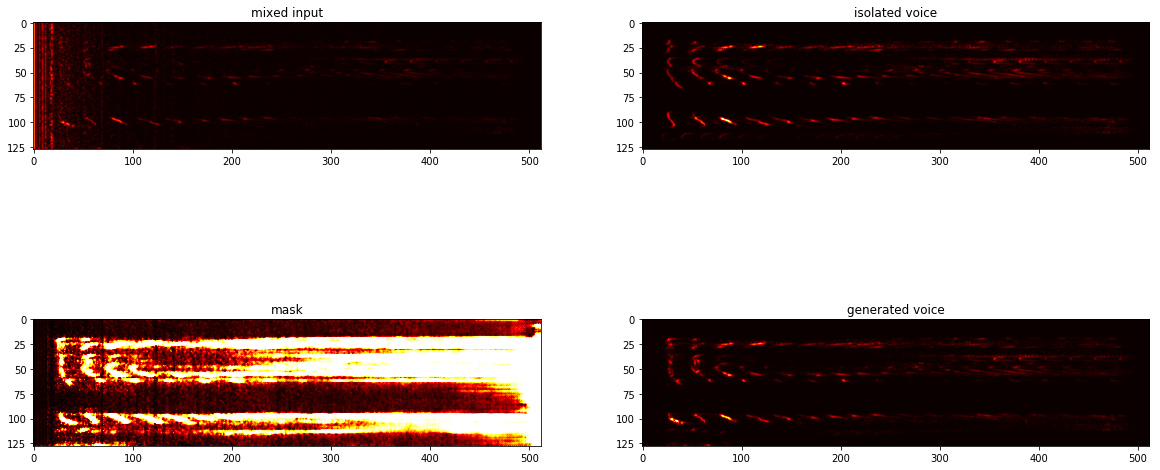

In [76]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_mag[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_mag[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est_mag[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

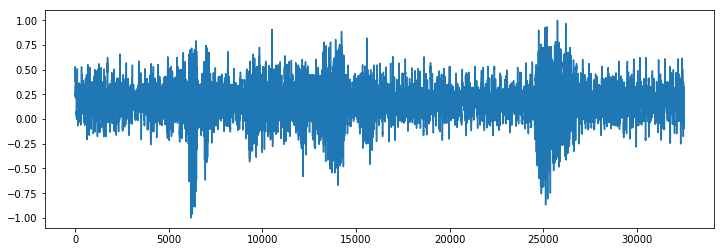

In [77]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

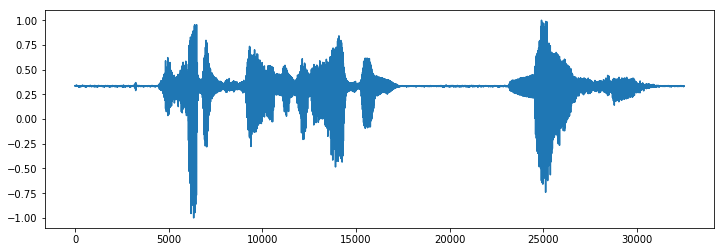

In [78]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

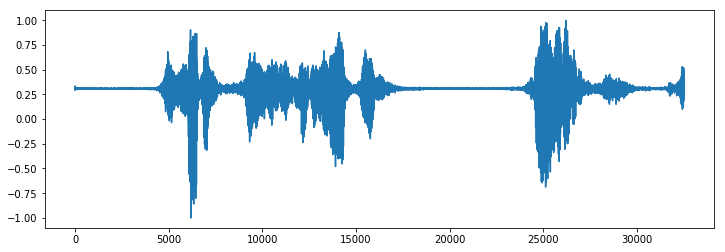

In [79]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

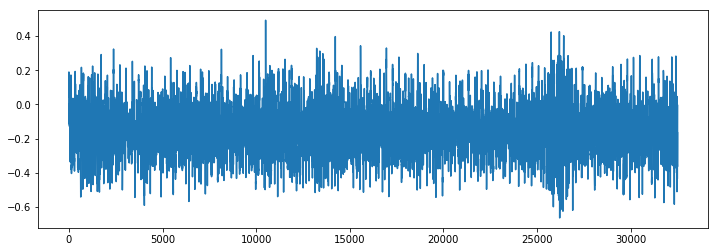

In [80]:
#  The background noise, by subtracting the voice on the waveform - doesn't seem to work
#print(metrics['mix'])
plt.figure(figsize=(12,4))
plt.plot(x,(mix_wave[i]-voice_wave[i]))
ipd.Audio((mix_wave[i]-voice_wave[i]).T, rate=sample_rate)

## Reconstruction Investigations

#### Background Noise Estimation

In [41]:
i=4

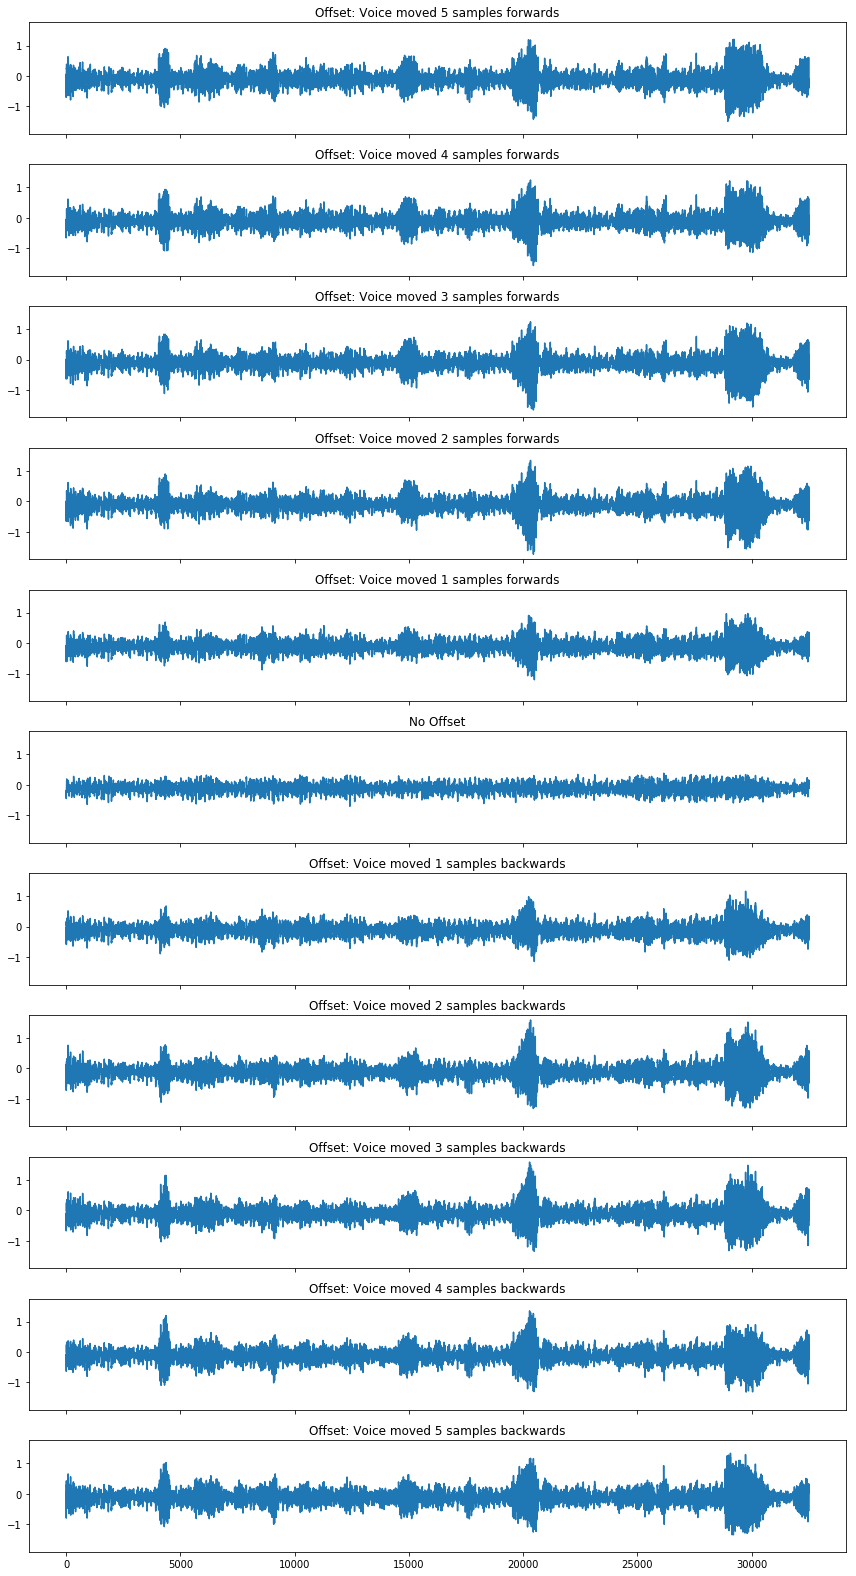

In [42]:
fig, ax = plt.subplots(11,1, figsize=(12,22), sharey=True, sharex=True)
j=0

for k in reversed(range(1, 6)):
    x =range(len(voice_wave[i][k:]))
    ax[j].plot(x,(mix_wave[i][:-k]-voice_wave[i][k:]))
    ax[j].set_title('Offset: Voice moved {} samples forwards'.format(k))
    #ipd.Audio((mix_wave[i][k:]-voice_wave[i][:-k]).T, rate=sample_rate)
    j+=1
x =range(len(mix_wave[i]))
ax[j].plot(x,(mix_wave[i]-voice_wave[i]))
ax[j].set_title('No Offset')
j+=1
for k in range(1, 6):
    x =range(len(mix_wave[i][k:]))
    ax[j].plot(x,(mix_wave[i][k:]-voice_wave[i][:-k]))
    ax[j].set_title('Offset: Voice moved {} samples backwards'.format(k))
    #ipd.Audio((mix_wave[i][k:]-voice_wave[i][:-k]).T, rate=sample_rate)
    j+=1
plt.tight_layout()

#### Time Offset

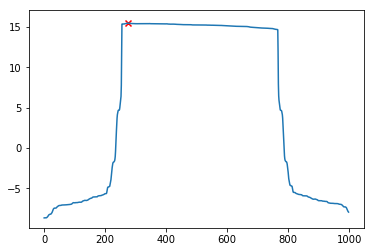

In [340]:
x = range(len(sdrs))
max_idx = sdrs.index(max(sdrs))
plt.plot(x,sdrs)
plt.scatter(max_idx,sdrs[max_idx], c='r', marker = 'x')

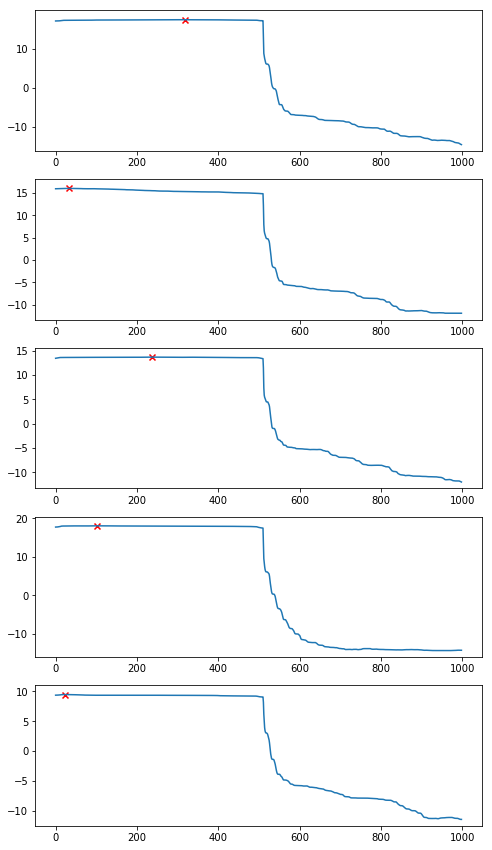

In [29]:
fig, ax = plt.subplots(5,1, figsize=(8,15))
for i in range(len(sdrs)):
    x = range(len(sdrs[i]))
    max_idx = sdrs[i].index(max(sdrs[i]))
    ax[i].plot(x,sdrs[i])
    ax[i].scatter(max_idx,sdrs[i][max_idx], c='r', marker = 'x')